# ALPro tests
This notebook is designed to document some simple tests of axion propagation problems to build inuition (and also test the code). First let's import modules and provide some constants for converting to natural units and back.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import constants as c
import alpro 
print (alpro.__file__)
alpro.util.set_default_plot_params()
UNIT_LENGTH= 50676.79373667135
UNIT_GAUSS = 0.01953548032
HBAR_EV = 6.582119569e-16
c.MELEC = 9.10938356e-28
c.PARSEC = 3.0857e18
c.E = 4.8032045057134676e-10
Pfunc_to_test = alpro.get_P
implementation="numba"

/Users/matthews/Library/Python/3.7/lib/python/site-packages/alpro/__init__.py


In [2]:
#this our energy array in units of eV
energy = np.logspace(5,7,1000)

# set parameters of problem for all of the basic tests (Marsh test uses different values)
B = 1e-5          # 10 micro G
g = 1e-13 * 1e-9   # 1e-9 GeV^-1
mass = 1e-12     # 1e-12 eV
L = 10.0          # 10 kpc
ne = 100          # 1 particle cm^-3 (sets plasma frequency)

#omega_pl = np.sqrt(4.0 * np.pi * c.E * c.E * ne / c.MELEC) * HBAR_EV
#print (omega_pl)

### Analytic Test
First, let's compare an idealised pure polarization state solution to the analytic solution given by
$$ P_{\gamma \rightarrow a} = \frac{\Theta^2}{1+\Theta^2} \sin^2 (\Delta_{\rm eff} \sqrt{1+\Theta^2} L) $$

7.427242447944145e-08


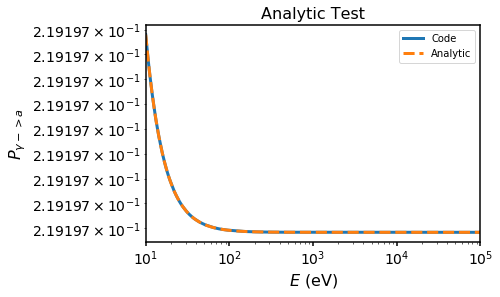

In [18]:
energy = np.logspace(1,5,10000)
# set parameters of problem for all of the basic tests (Marsh test uses different values)
B = 1e-5          # 10 micro G
g = (10.0 ** -12.3) * 1e-9   # 1e-9 GeV^-1
mass = 1e-12     # 1e-12 eV
L = 1500.0          # 10 kpc
ne = 1e-3        # 1 particle cm^-3 (sets plasma frequency)
#0.0007252461538657901
ne = 0.0007252461
#print ( np.fabs(ne-0.0007252461538657901)/0.0007252461538657901)

# function to get analytic prediction
def get_prediction(energy, mass, M, omega_pl, B, distance, norm=1):
    '''
    Get analytic prediction for idealised conversion probability.
    This function is actually written according to the notation
    of de Angelis et al. 2010 rather than the above equation -
    but is equivalent.
    '''
    SIM_UNITS = norm
    energy2 = energy / SIM_UNITS
    mass2 = mass / SIM_UNITS
    M2 = M / SIM_UNITS
    omega_pl2 = omega_pl / SIM_UNITS
    distance2 = distance * SIM_UNITS
    B2 = B / SIM_UNITS / SIM_UNITS
    Delta_PL = -(omega_pl2 * omega_pl2) / 2.0 / energy2
    Delta_AA = -(mass2 * mass2) / 2.0 / energy2
    Delta_AG = B2 / 2.0 / M2
    #print (Delta_PL,  Delta_AA, Delta_AG)
    x = (Delta_PL - Delta_AA) ** 2
    Delta_OSC = np.sqrt (x + (4.0 * Delta_AG * Delta_AG))
    term1 = (B2 / M2 / Delta_OSC)**2
    #print ("TERM:", term1)
    term2 = np.sin(Delta_OSC * distance2 / 2.0)**2
    prediction = term1 * term2
    return (prediction, term1)

# Initial state {0,1,0}
Ainit = np.zeros( (len(energy),6))
Ainit[:,2] = 1.0
phi = np.zeros_like(energy) #aligned field

# get code result and plot 
P, Anew= Pfunc_to_test(energy, Ainit, phi, B, L, g, mass, ne)
plt.plot(energy, 1-P, label="Code", lw=3)

# get theoretical prediction and plot
omega_pl = np.sqrt(4.0 * np.pi * c.E * c.E * ne / c.MELEC) * HBAR_EV
prediction, alpha = get_prediction (energy, mass, 1.0/g, omega_pl, B * UNIT_GAUSS, L * 1000.0 * c.PARSEC * UNIT_LENGTH)
plt.plot(energy, 1-prediction,  ls="--", lw=3, label="Analytic")

#print (mass, omega_pl)
prediction, alpha = get_prediction (energy, mass, 1.0/g, omega_pl, B * UNIT_GAUSS, L * 1000.0 * c.PARSEC * UNIT_LENGTH, norm=1e-15)
#plt.plot(energy, prediction,  ls="-", lw=3, label="Analytic scaled")


# label
plt.loglog()
plt.legend()
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->a}$", fontsize=16)
plt.xlim(1e1,1e5)
title = plt.title("Analytic Test", fontsize=16)

### Discretisation Test
In our second test, we compare the result from 1 uniform cell of size L to 10 uniform cells of size L/10. This should give an identical result. We use a pure polarisation state {0,1,0} and a B-field aligned with the x axis. 

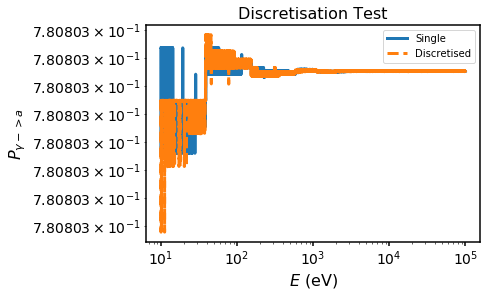

In [4]:
# re-initialise 
Ainit = np.zeros( (len(energy),6))
Ainit[:,2] = 1.0
phi = np.zeros_like(energy)

# get single probability and plot
P1, Anew = Pfunc_to_test(energy, Ainit, phi, B, L, g, mass, ne)
plt.plot(energy, P1, c="C0", lw=3, label="Single")
plt.loglog()


# now do the discretised version
Ainit = np.zeros( (len(energy),6))
Ainit[:,2] = 1.0
Anew = Ainit
phi = np.zeros_like(energy)
Nshells = 10
for i in range(Nshells):
    Ainit = Anew
    P1, Anew = Pfunc_to_test(energy, Ainit, phi, B, L/Nshells, g, mass, ne)

plt.plot(energy, P1, c="C1", ls="--", lw=3, label="Discretised")

# label
plt.legend()
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->a}$", fontsize=16)
title = plt.title("Discretisation Test", fontsize=16)

### Flip Test
Now, we do the same as the above, but flip the field alternately in every cell by $\pi$ radians. This means the field goes from having this structure: $\rightarrow \rightarrow \rightarrow \rightarrow$ to this $\rightarrow \leftarrow \rightarrow \leftarrow$. My intuition was that this should give the same result - but it does not. Note that it does give the same result if **every** cell has been rotated by $\pi$. 

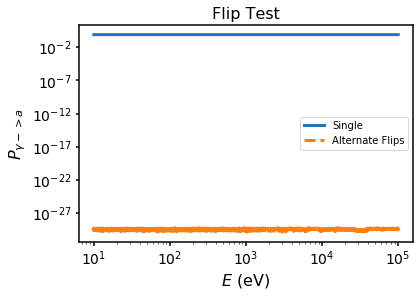

In [5]:
Ainit = np.zeros( (len(energy),6))
Ainit[:,2] = 1.0
phi = np.pi/2 * np.ones_like(energy) * 0.0
P1, Anew = Pfunc_to_test(energy, Ainit, phi, B, L, g, mass, ne)
# P2, Anew2 = alpro.get_P(energy, Ainit2, phi - np.pi/2, B, L, g, mass, ne)

# P = P2
plt.plot(energy, P1, c="C0", lw=3, label="Single")
plt.loglog()
# plt.ylim(0,1.2)
Nshells = 10

Ainit = np.zeros( (len(energy),6))
Ainit[:,2] = 1.0
phi = np.pi/2 * np.ones_like(energy) * 0.0
for i in range(Nshells):
    # this gives alternating 0 and pi.
    offset = 0.5 * (1 + ((-1.0) ** (i))) * np.pi
    P1, Anew = Pfunc_to_test(energy, Ainit, phi - offset, B, L/Nshells, g, mass, ne)
    Ainit = Anew
    
plt.plot(energy, P1, c="C1", ls="--", lw=3, label="Alternate Flips")

# label
plt.legend()
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->a}$", fontsize=16)
title = plt.title("Flip Test", fontsize=16)

### Test v Marsh / Libanov
This tests a uniform field model from Libanov and Troitsky against David Marsh's code and from data digitised from the Libanov paper. This test uses a large scale uniform field and energies in the GeV regime. Note that this is now the **survival** probability on a linear axis. 
We find cosmetically perfect agreement between our results and Marsh. the Libanov results are smoothed with the Fermi response which is presumably the reason for the difference.

Text(0.5, 1.0, 'Uniform Perseus Test')

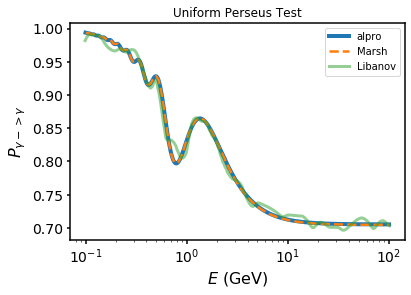

In [6]:
energies = np.logspace(8,11,1000)
s = alpro.Survival("libanov", implementation=implementation)
s.init_model()
mass = 1e-9
g = 1e-11 * 1e-9
s.set_params(g, mass)
s.domain.rm = 0.0
P = s.get_curve(energies, 1.0, 93.0, r0=0.0)
plt.plot(energies / 1e9, 1-P, lw=4, label="alpro")
plt.semilogx()

# load data from Marsh and Libanov codes 
import os
folder = os.path.dirname(alpro.__file__)
energies_m, P_m = np.genfromtxt("{}/data/marsh_test.dat".format(folder), unpack=True)
plt.plot(energies_m, P_m, lw=2.5, ls="--", label="Marsh")
energies_l, P_l = np.genfromtxt("{}/data/libanov.dat".format(folder), unpack=True)
plt.plot(energies_l, P_l, ls="-", alpha=0.5, label="Libanov", lw=3)

plt.xlabel("$E$ (GeV)", fontsize=16)
plt.ylabel("$P_{\gamma->\gamma}$", fontsize=16)
plt.legend()
plt.title("Uniform Perseus Test")

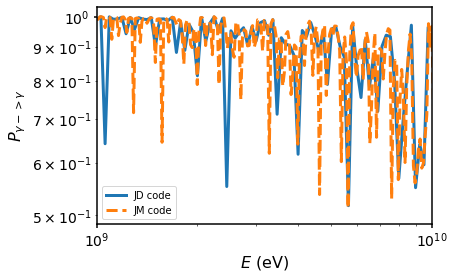

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 
import constants as c
import alpro 
alpro.util.set_default_plot_params()
# now we're going to test against Jamie Davies' code.
s1 = s = alpro.Survival("davies", implementation=implementation)
s1.domain = alpro.models.FieldModel(None)
mass = 1e-8
g = 1e-11 * 1e-9
s1.set_params(g, mass)

r, B, phi, ne = np.genfromtxt("ClusterField.txt", unpack=True)
last_index =-10
s1.domain.ne = ne
s1.domain.phi = phi
r = np.append(r, 500)
# s1.domain.r=r[:-1]
s1.domain.r = 0.5 * (r[1:] + r[:-1])
s1.domain.B = B * 1e-6
#s1.domain.deltaL = 0.111111111111 * np.ones_like(s1.domain.r)
#r = np.linspace(0,500,num=4500)
s1.domain.deltaL = r[1:] - r[:-1] 

energies, P_jamie = np.genfromtxt('noqedorcmb_james_test_m10_g1e11_pggs.txt', unpack=True)
energies2 = np.logspace(9,14,1000)
P, Prad = s1.propagate(s1.domain, energies2)

plt.plot(energies, P_jamie, label="JD code")
plt.plot(energies2, 1.0 - P, label="JM code", ls="--")
plt.semilogx()
plt.semilogy()
plt.xlim(1e9,1e10)
plt.legend()
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->\gamma}$", fontsize=16)
plt.savefig("test.png", dpi=200)

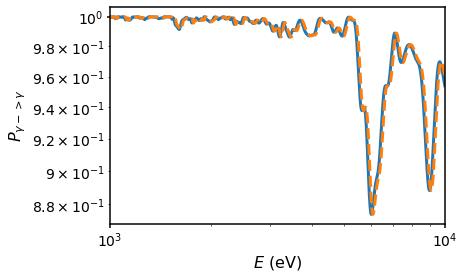

In [8]:
energies, P_jamie = np.genfromtxt('james_field_mm13_gm12p3_pggs.txt', unpack=True)
plt.plot(energies, P_jamie, label="JD code", ls="-")

energies = np.logspace(3,4,10000)
# now we're going to test against Jamie Davies' code.
s1 = s = alpro.Survival("davies", implementation=implementation)
s1.domain = alpro.models.FieldModel(None)

logg = 12.3
logm = 13
mass = (10.0**-logm)
g = (10.0**-logg) * 1e-9
s1.set_params(g, mass)

r1, r2, Bx, By, ne = np.genfromtxt("domain_seed_100_1275b.dat", unpack=True)
s1.domain.ne = ne 
s1.domain.phi = np.arctan(By/Bx) 
B = np.sqrt(Bx * Bx + By * By) 
s1.domain.r = r2
s1.domain.B = B 
s1.domain.deltaL = (r2 - r1) 

P, Prad = s1.propagate(s1.domain, energies)
p_to_plot = 1.0 - P

plt.plot(energies, p_to_plot, label="JM code", ls="--")
plt.semilogx()
plt.semilogy()
plt.xlim(1e3,1e4)
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->\gamma}$", fontsize=16)
plt.savefig("test_1275.png", dpi=200)

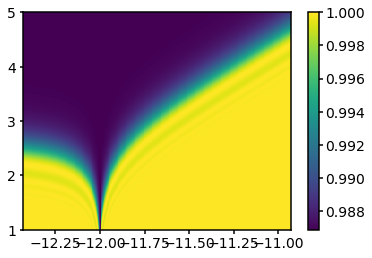

In [34]:
energy = np.logspace(1,5,10000)
# set parameters of problem for all of the basic tests (Marsh test uses different values)
B = 1e-5          # 10 micro G
g = (10.0 ** -12.3) * 1e-9   # 1e-9 GeV^-1
mass = 1e-12     # 1e-12 eV
L = 15.0          # 10 kpc
ne = 1e-3        # 1 particle cm^-3 (sets plasma frequency)
#0.0007252461538657901
ne = 0.0007252461

nes = np.logspace(-4,-1,300)
P1 = np.zeros((len(nes), len(energy)))
P2 = np.zeros((len(nes), len(energy)))
omega_pls = np.sqrt(4.0 * np.pi * c.E * c.E * nes / c.MELEC) * HBAR_EV

for i, ne in enumerate(nes):
    # Initial state {0,1,0}
    Ainit = np.zeros( (len(energy),6))
    Ainit[:,2] = 1.0
    phi = np.zeros_like(energy) #aligned field

    # get code result and plot 
    P, Anew= Pfunc_to_test(energy, Ainit, phi, B, L, g, mass, ne)
    #plt.plot(energy, 1-P, label="Code", lw=3)
    P1[i,:] = 1.0-P

    # get theoretical prediction and plot
    omega_pl = np.sqrt(4.0 * np.pi * c.E * c.E * ne / c.MELEC) * HBAR_EV
    prediction, alpha = get_prediction (energy, mass, 1.0/g, omega_pl, B * UNIT_GAUSS, L * 1000.0 * c.PARSEC * UNIT_LENGTH)
    #plt.plot(energy, 1-prediction,  ls="--", lw=3, label="Analytic")
    P2[i,:] = 1.0-prediction

    #print (mass, omega_pl)
    #prediction, alpha = get_prediction (energy, mass, 1.0/g, omega_pl, B * UNIT_GAUSS, L * 1000.0 * c.PARSEC * UNIT_LENGTH, norm=1e-15)
    #plt.plot(energy, prediction,  ls="-", lw=3, label="Analytic scaled")
    

plt.pcolormesh(np.log10(omega_pls), np.log10(energy), P2.T)

plt.colorbar()
#plt.xlim(-12.1,-11.9)
# label
# plt.loglog()
# plt.legend()
# plt.xlabel("$E$ (eV)", fontsize=16)
# plt.ylabel("$P_{\gamma->a}$", fontsize=16)
# plt.xlim(1e1,1e5)
# title = plt.title("Analytic Test", fontsize=16)